In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
import ray
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

c:\Users\Seth Dwumah\Desktop\madewithml\.venv\lib\site-packages\ray\_private\parameter.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(ignore_reinit_error=True)

2025-07-10 03:40:32,357	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [3]:
ray.cluster_resources()

{'memory': 1013093991.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 506546995.0,
 'node:__internal_head__': 1.0,
 'CPU': 8.0}

In [4]:
num_workers = 4
resources_per_worker = {"CPU": 1, "GPU": 0.5}

In [5]:
if ray.cluster_resources().get("CPU", 0) < num_workers * resources_per_worker["CPU"]:
    raise ValueError("Not enough CPU resources available for the specified number of workers.")

In [6]:
# Data ingestion
DATASET_LOC = "datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [7]:

df.isna().sum()

id             0
created_on     0
title          0
description    0
tag            0
dtype: int64

In [8]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [9]:
# split dataset
test_size =0.2
train_df, val_df = train_test_split(df,test_size=test_size, stratify=df.tag, random_state=1234)

In [10]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [11]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size)/ test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

In [12]:
#Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

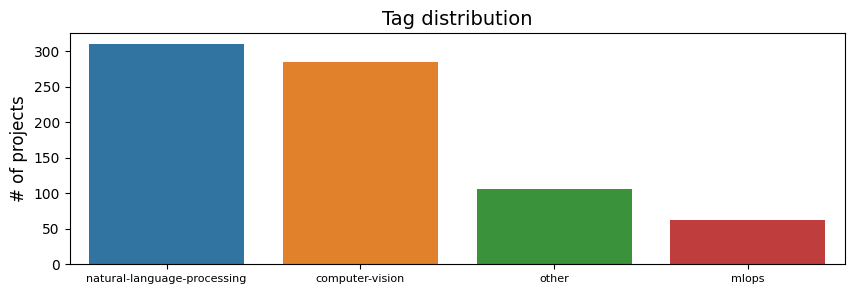

In [13]:
# plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags,rotation=0, fontsize=8)
plt.title("Tag distribution",fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

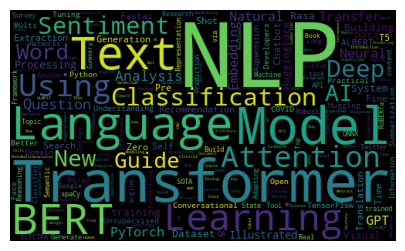

In [14]:
# Wordcloud - title
tag = "natural-language-processing"
plt.figure(figsize=(10,3))
subset=df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(stopwords=STOPWORDS, background_color="black",
                  collocations=False,width=500,height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)


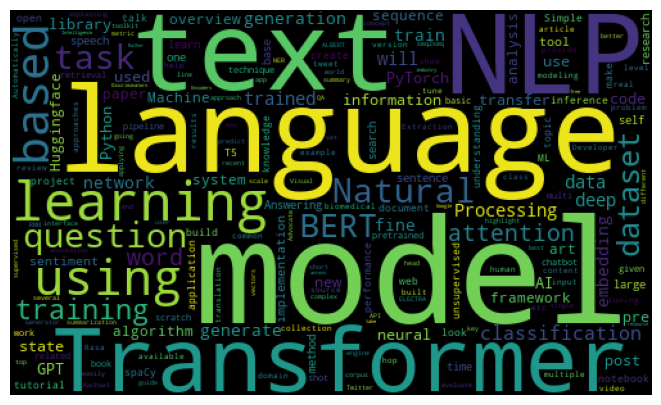

In [15]:
# Wordcloud - Description
tag = "natural-language-processing"
plt.figure(figsize=(10,5))
subset=df[df.tag==tag]
text = subset.description.values
cloud = WordCloud(stopwords=STOPWORDS, background_color="black",
                  collocations=False,width=500,height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

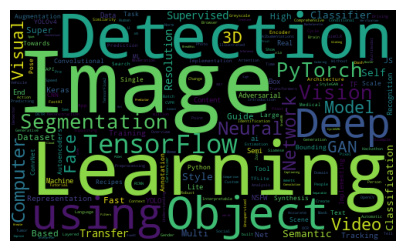

In [16]:
# Wordcloud - Description
tag = "computer-vision"
plt.figure(figsize=(10,3))
subset=df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(stopwords=STOPWORDS, background_color="black",
                  collocations=False,width=500,height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

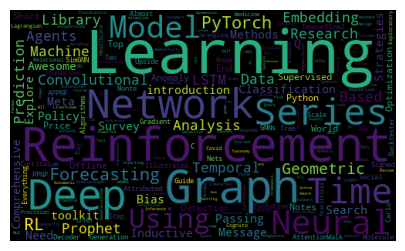

In [17]:
# Wordcloud - Description
tag = "other"
plt.figure(figsize=(10,3))
subset=df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(stopwords=STOPWORDS, background_color="black",
                  collocations=False,width=500,height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

## Feature Engineering

In [18]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# iput 
df['text'] = df['title'] + " " + df['description']

In [21]:
df.text

0      Comparison between YOLO and RCNN on real world...
1      Show, Infer & Tell: Contextual Inference for C...
2      Awesome Graph Classification A collection of i...
3      Awesome Monte Carlo Tree Search A curated list...
4      AttentionWalk A PyTorch Implementation of "Wat...
                             ...                        
759    A Survey of the State of Explainable AI for NL...
760    Topic Modeling with BERT Leveraging 🤗 Transfor...
761    OpenMMLab Computer Vision MMCV is a python lib...
762    Machine Learning Methods Explained (+ Examples...
763    Rasoee A powerful web and mobile application t...
Name: text, Length: 764, dtype: object

In [22]:
#Cleaning
#nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

def clean_text(text, stopwords=STOPWORDS):
    """ 
    Clean raw exit string
    
        """
    text = text.lower()
    # remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)
    # remove special characters and digits
    text = re.sub(r"([!\"'#$%&'()*+,-./:;<=>?@[\]^_`{|}~\d])", r" \r ", text) # add spaceing
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove special characters
    text = re.sub(' +', ' ', text) # remove extra spaces
    text = text.strip()
    text = re.sub(r"http\S+", "", text) # remove urls
    text = re.sub(r"www\S+", "", text) # remove urls
    text = re.sub(r"@\S+", "", text) # remove mentions
    text = re.sub(r"#\S+", "", text) # remove hashtags
    return text


In [23]:
# Apply cleaning to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [24]:
# Dataframe cleanup
df = df.drop(columns=['id','created_on','title', 'description'], errors='ignore')
df = df.dropna(subset=['tag'])
df = df[['text','tag']]

df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [25]:
##Encoding
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [26]:
# encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [27]:
# decode labels
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]



In [28]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [29]:
# Tokenizer
import numpy as np
from transformers import BertTokenizer

In [30]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

c:\Users\Seth Dwumah\Desktop\madewithml\.venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [31]:
# Tokenize function
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], attention_mask=encoded_inputs["attention_mask"], labels=np.array(batch["tag"]))


In [32]:
# Tokenization 
tokenize(df.head(1))

c:\Users\Seth Dwumah\Desktop\madewithml\.venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'labels': array([2], dtype=int64)}

In [33]:
def preprocess(df,class_to_index):
    # encode labels
    df["text"] = df['title'] + " " + df['description']
    df["text"] = df.text.apply(clean_text)
    df = df.drop(columns=['id','created_on','title', 'description'], errors='ignore')
    df = df[['text','tag']]
    df["tag"] = df["tag"].map(class_to_index)
    outputs = tokenize(df)
    return outputs


In [34]:

preprocess(df=train_df,class_to_index=class_to_index)

c:\Users\Seth Dwumah\Desktop\madewithml\.venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'labels': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1,

## Distributed Training


In [35]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor
import torch.nn as nn
from transformers import BertModel

In [36]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [37]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [38]:
# Custom preprocessor class

class CustomPreprocessor(Preprocessor):
    """" Custom Preprocessor class"""
    def _fit(self, ds):
        tags = ds.unique(column=tag)
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    def _transform_pandas(self, batch):
        return preprocess(batch, class_to_indec=self.class_to_index)
    

In [39]:
# Pretrained Model
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768

In [41]:
llm

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm,dropout_p,embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)
        
    def forward(self, batch):
        ids, masks = batch['ids'],batch['masks']
        seq, pool =self.llm(input_ids=ids, attention_mask=masks)
        z =self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)
        y_pred = torch.argmax(z,dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self,batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z).cpu().numpy()
        return y_probs
    

In [ ]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print(model.named_parameters)

In [16]:
# data distribution
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [ ]:
# Ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)